In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [43]:
df=pd.read_csv(r'F:\Adult-Income-Prediction\data\processed.csv')

## some columns will be dropped for ML becuase there is no information gain in them 
#### remove final weight becuase i couldn't see the benefit of a model seeing how much a sample is representative of the distbution also since it was weirdly scaled
#### remove education since education.num is a better representative of how much educated a person is 
#### martial status and relationship is closely related to had to remove the one that had less cardinalty
#### replaced capital gain and capital loss for net capital
#### predictve power or feature importance of workclass and relationship columns isn't large enough to justify keeping them especially with their cardinality

In [44]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [45]:
df['net_capital']=df['capital.gain']-df['capital.loss']

In [46]:
df.drop(inplace=True,axis=1,columns=['fnlwgt','education','marital.status','capital.gain','capital.loss','relationship','occupation','workclass'])

In [47]:
df.head()

age  education.num   race     sex  hours.per.week native.country  income  \
0   90              9  White  Female              40            USA       0   
1   82              9  White  Female              18            USA       0   
2   66             10  Black  Female              40            USA       0   
3   54              4  White  Female              40            USA       0   
4   41             10  White  Female              40            USA       0   

   net_capital  
0        -4356  
1        -4356  
2        -4356  
3        -3900  
4        -3900

In [48]:
df['strat_col']=df['sex'].astype(str)+'_'+df['income'].astype(str)

In [49]:
train,test=train_test_split(df,random_state=42,test_size=0.2,stratify=df['strat_col'])

In [50]:
train.drop('strat_col', inplace=True, axis=1)
test.drop('strat_col', inplace=True, axis=1)

In [51]:
train.head()

age  education.num   race     sex  hours.per.week native.country  \
4955    63              9  White    Male               6            USA   
24772   29             13  White    Male              35            USA   
9751    23              9  White    Male              55            USA   
19292   60              9  White    Male              40            USA   
3136    46             10  White  Female              40            USA   

       income  net_capital  
4955        0            0  
24772       1            0  
9751        0            0  
19292       0            0  
3136        0         5013

In [52]:
# Identify numeric columns to scale (excluding the target 'income')
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'income' in numeric_cols:
    numeric_cols.remove('income')

scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

In [53]:
# One-hot encode nominal (categorical, non-numeric) columns except the target
nominal_cols = train.select_dtypes(include=['object']).columns.tolist()
# Use pandas get_dummies for one-hot encoding, fit on train, align test
train = pd.get_dummies(train, columns=nominal_cols, drop_first=True)
test = pd.get_dummies(test, columns=nominal_cols, drop_first=True)

# Align test columns to train columns (add missing columns as 0)
test = test.reindex(columns=train.columns, fill_value=0)
train.head()

age  education.num  hours.per.week  income  net_capital  \
4955   1.793984      -0.418707       -2.797886       0    -0.134174   
24772 -0.699080       1.133155       -0.440823       1    -0.134174   
9751  -1.139032      -0.418707        1.184738       0    -0.134174   
19292  1.574008      -0.418707       -0.034433       0    -0.134174   
3136   0.547452      -0.030742       -0.034433       0     0.531456   

       race_Asian-Pac-Islander  race_Black  race_Other  race_White  sex_Male  \
4955                     False       False       False        True      True   
24772                    False       False       False        True      True   
9751                     False       False       False        True      True   
19292                    False       False       False        True      True   
3136                     False       False       False        True     False   

       native.country_USA  
4955                 True  
24772                True  
9751                 True  
19292                True  
3136                 True

## Model Training and Evaluation Workflow
We will use two models: **Logistic Regression** and **Decision Tree**. For each model, we will:

1. **Train the model** on the processed data.
2. **Visualize the decision boundary** using PCA-reduced features.
3. **Display the confusion matrix and classification metrics**.

After evaluating both models on the original data, we will address class imbalance using **RandomUnderSampler**. We will then retrain both models on the balanced data, visualize their decision boundaries, and display updated confusion matrices and metrics.

### Logistic Regression: Training, Decision Boundary, and Evaluation

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Split features and target
y_train = train['income']
X_train = train.drop('income', axis=1)
y_test = test['income']
X_test = test.drop('income', axis=1)

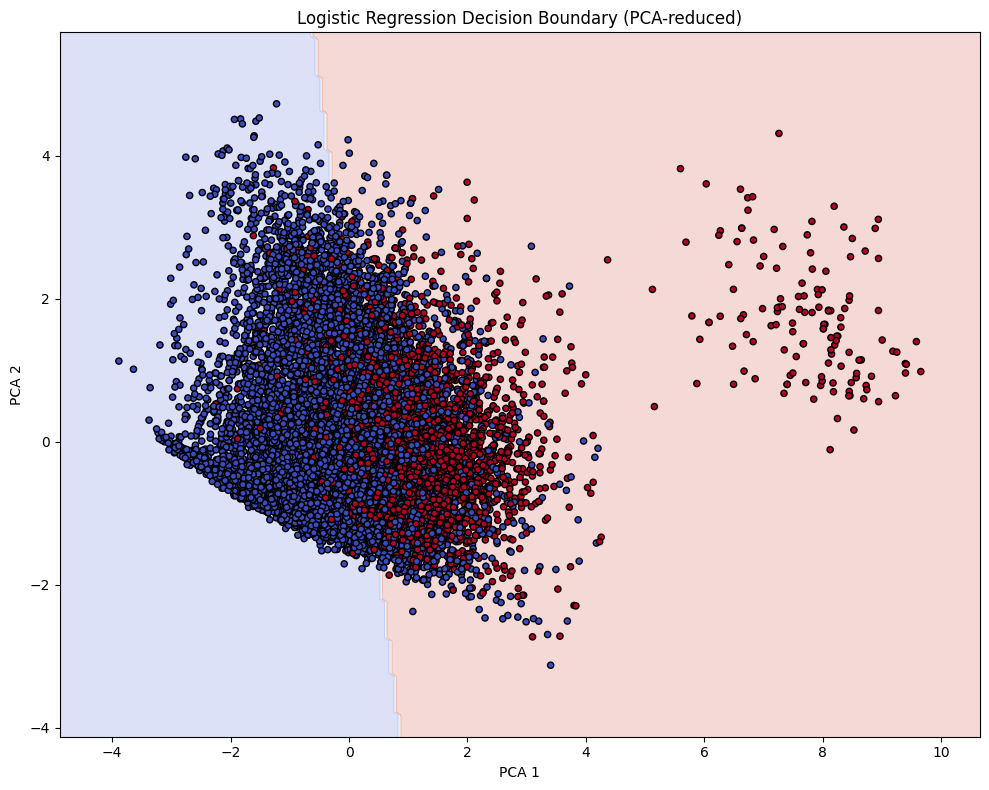

In [55]:

# Reduce to 2D for visualization using PCA
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train_2d, y_train)

# Plot decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
plt.title('Logistic Regression Decision Boundary (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.savefig('../assets/logistic_regression_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

### Logistic Regression: Confusion Matrix and Metrics

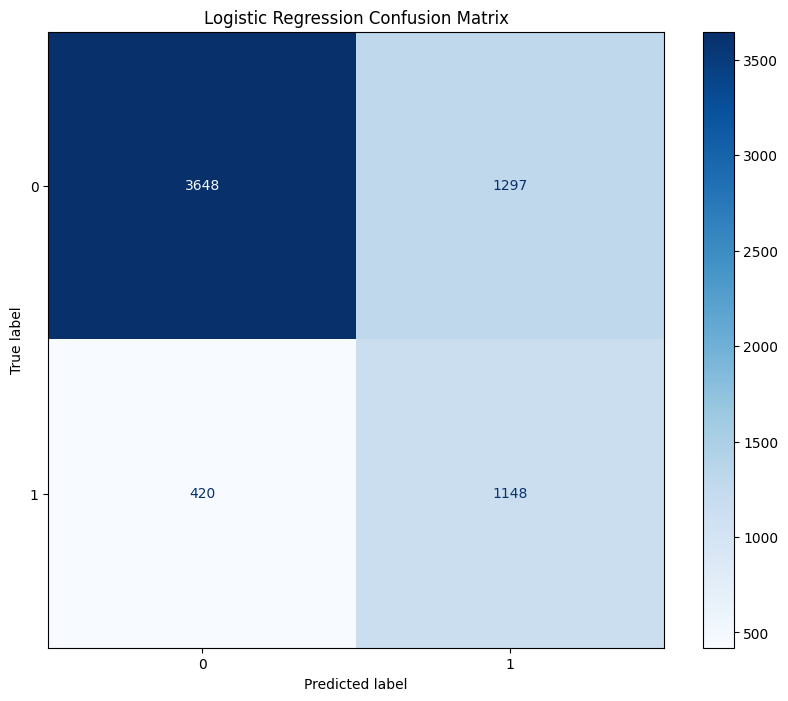


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      4945
           1       0.47      0.73      0.57      1568

    accuracy                           0.74      6513
   macro avg       0.68      0.73      0.69      6513
weighted avg       0.79      0.74      0.75      6513

Train Accuracy: 0.744
Test Accuracy: 0.736


In [56]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on train and test
logreg_train_pred = logreg.predict(X_train_2d)
logreg_test_pred = logreg.predict(X_test_2d)

# Confusion matrix plot (bigger)
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_pred, cmap='Blues', ax=ax)
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('../assets/logistic_regression_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Metrics for test set
print("\nTest Classification Report:")
print(classification_report(y_test, logreg_test_pred))

# Overfitting check
logreg_train_acc = logreg.score(X_train_2d, y_train)
logreg_acc = logreg.score(X_test_2d, y_test)
print(f"Train Accuracy: {logreg_train_acc:.3f}")
print(f"Test Accuracy: {logreg_acc:.3f}")

### Decision Tree: Training, Decision Boundary, and Evaluation

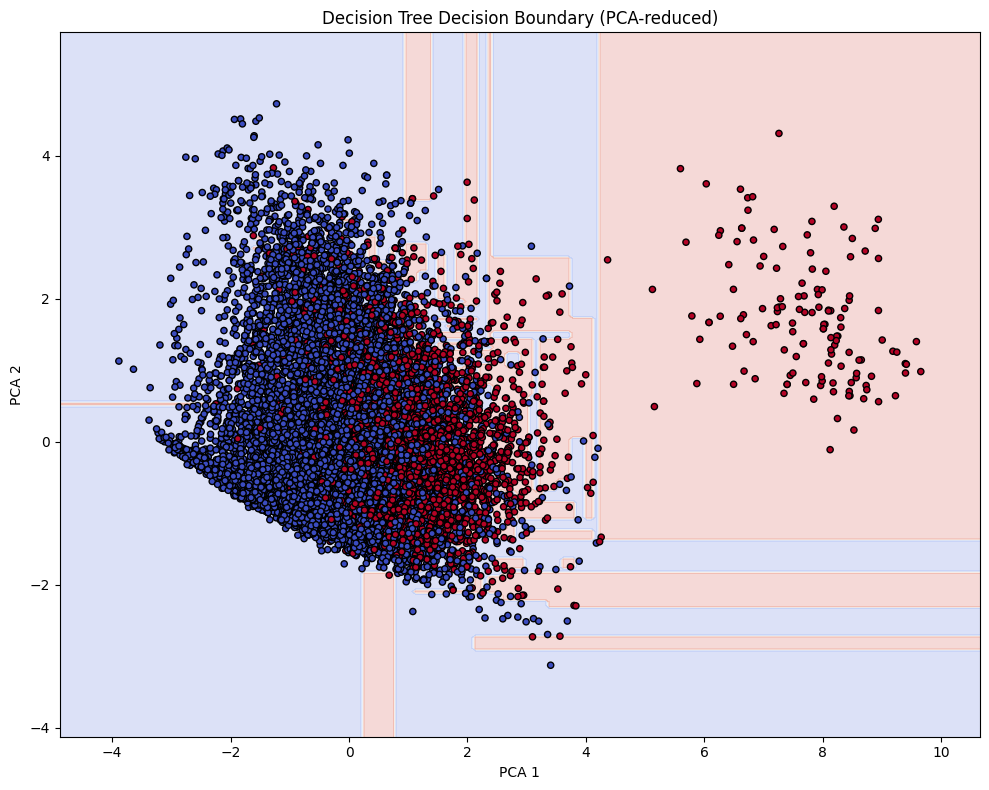

Decision Tree Train Accuracy: 0.876
Decision Tree Test Accuracy: 0.724


In [57]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtree.fit(X_train_2d, y_train)

# Plot decision boundary
Z = dtree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
plt.title('Decision Tree Decision Boundary (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.savefig('../assets/decision_tree_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

# Accuracy
dtree_acc = dtree.score(X_test_2d, y_test)
dtree_train_acc = dtree.score(X_train_2d, y_train)
print(f"Decision Tree Train Accuracy: {dtree_train_acc:.3f}")
print(f"Decision Tree Test Accuracy: {dtree_acc:.3f}")

### Decision Tree: Confusion Matrix and Metrics

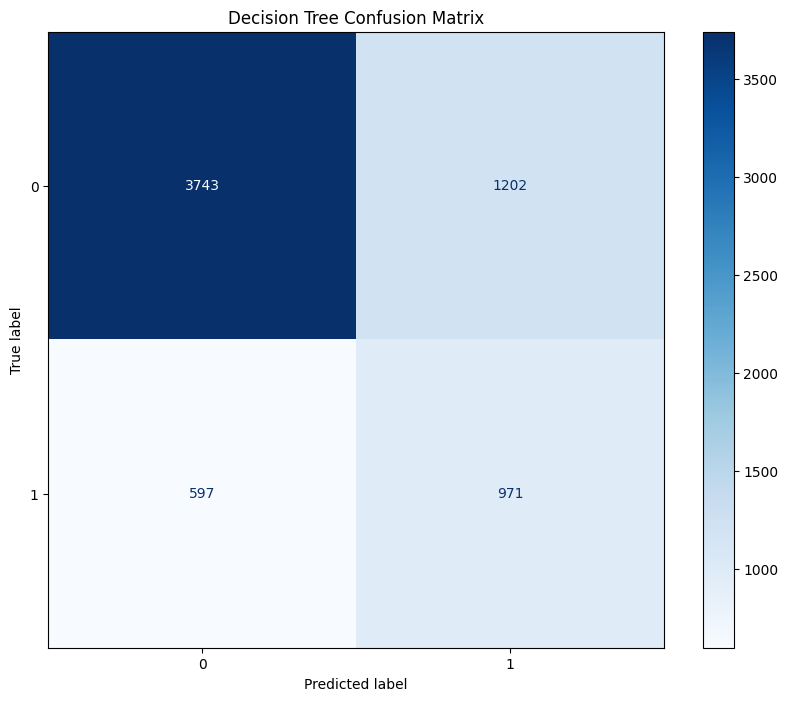

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4945
           1       0.45      0.62      0.52      1568

    accuracy                           0.72      6513
   macro avg       0.65      0.69      0.66      6513
weighted avg       0.76      0.72      0.74      6513

Train Accuracy: 0.876
Test Accuracy: 0.724


In [58]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict on train and test
dtree_train_pred = dtree.predict(X_train_2d)
dtree_test_pred = dtree.predict(X_test_2d)

# Confusion matrix plot (bigger)
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, dtree_test_pred, cmap='Blues', ax=ax)
plt.title('Decision Tree Confusion Matrix')
plt.savefig('../assets/decision_tree_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Metrics for test set
print(classification_report(y_test, dtree_test_pred))
print(f"Train Accuracy: {dtree_train_acc:.3f}")
print(f"Test Accuracy: {dtree_acc:.3f}")

### Addressing Class Imbalance with RandomUnderSampler
We will use imbalanced-learn's RandomUnderSampler to balance the classes in the training set. After undersampling, we will retrain both Logistic Regression and Decision Tree models, visualize their decision boundaries, and display confusion matrices and metrics for the balanced data.

In [59]:
from imblearn.under_sampling import RandomUnderSampler

# Only undersample the training set (never the test set)
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

# For PCA visualization, reduce the balanced data to 2D
X_train_bal_2d = pca.fit_transform(X_train_bal)

### Logistic Regression: Decision Boundary and Accuracy (Undersampled Data)

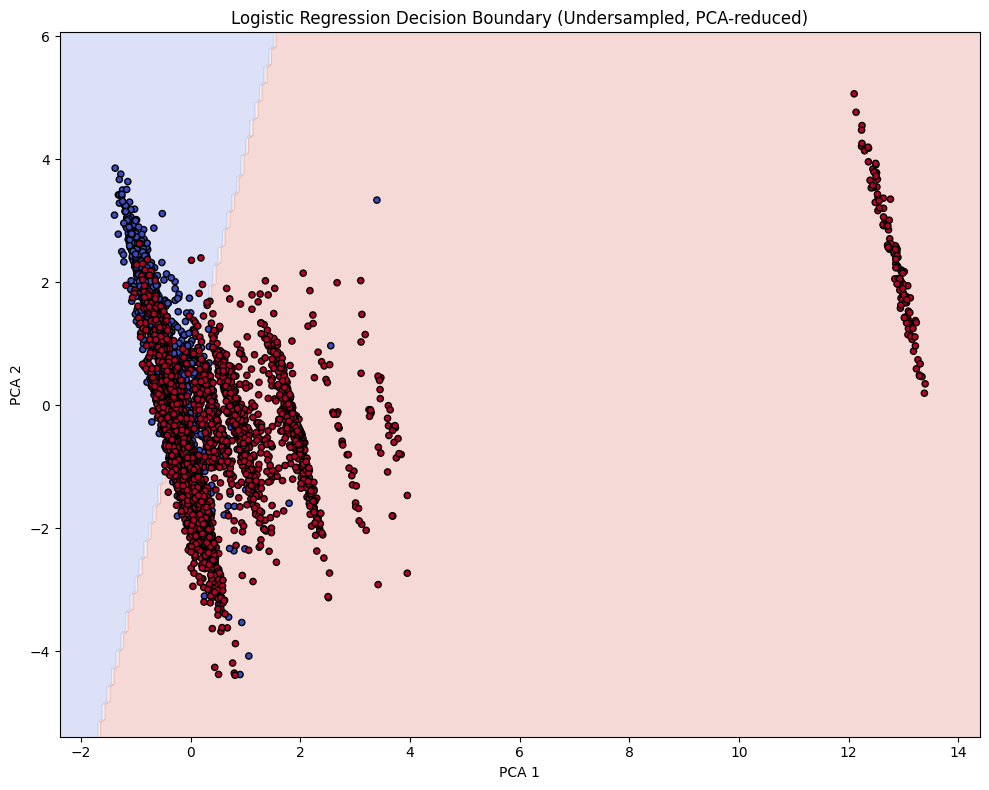

In [60]:
logreg_bal = LogisticRegression(max_iter=1000, random_state=42)
logreg_bal.fit(X_train_bal_2d, y_train_bal)

# Plot decision boundary
x_min, x_max = X_train_bal_2d[:, 0].min() - 1, X_train_bal_2d[:, 0].max() + 1
y_min, y_max = X_train_bal_2d[:, 1].min() - 1, X_train_bal_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = logreg_bal.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X_train_bal_2d[:, 0], X_train_bal_2d[:, 1], c=y_train_bal, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
plt.title('Logistic Regression Decision Boundary (Undersampled, PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.savefig('../assets/logistic_regression_undersampled_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

### Logistic Regression: Confusion Matrix and Metrics (Undersampled)

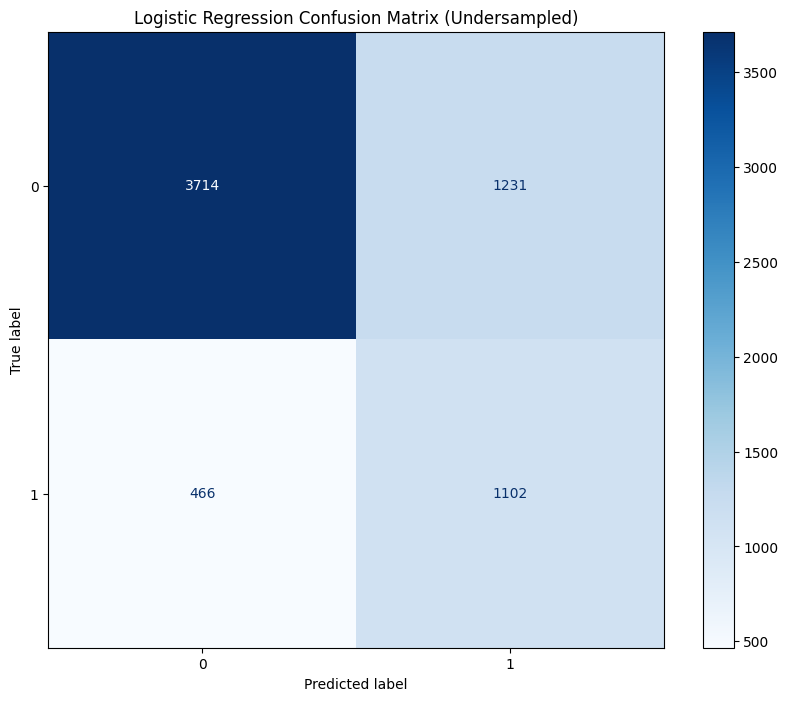

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      4945
           1       0.47      0.70      0.56      1568

    accuracy                           0.74      6513
   macro avg       0.68      0.73      0.69      6513
weighted avg       0.79      0.74      0.75      6513

Train Accuracy: 0.736
Test Accuracy: 0.739


In [61]:
# Evaluate on original test set (PCA-reduced)
X_test_2d = pca.transform(X_test)
logreg_bal_test_pred = logreg_bal.predict(X_test_2d)
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, logreg_bal_test_pred, cmap='Blues', ax=ax)
plt.title('Logistic Regression Confusion Matrix (Undersampled)')
plt.savefig('../assets/logistic_regression_undersampled_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(y_test, logreg_bal_test_pred))
print(f"Train Accuracy: {logreg_bal.score(X_train_bal_2d, y_train_bal):.3f}")
print(f"Test Accuracy: {logreg_bal.score(X_test_2d, y_test):.3f}")

### Decision Tree: Decision Boundary and Accuracy (Undersampled Data)

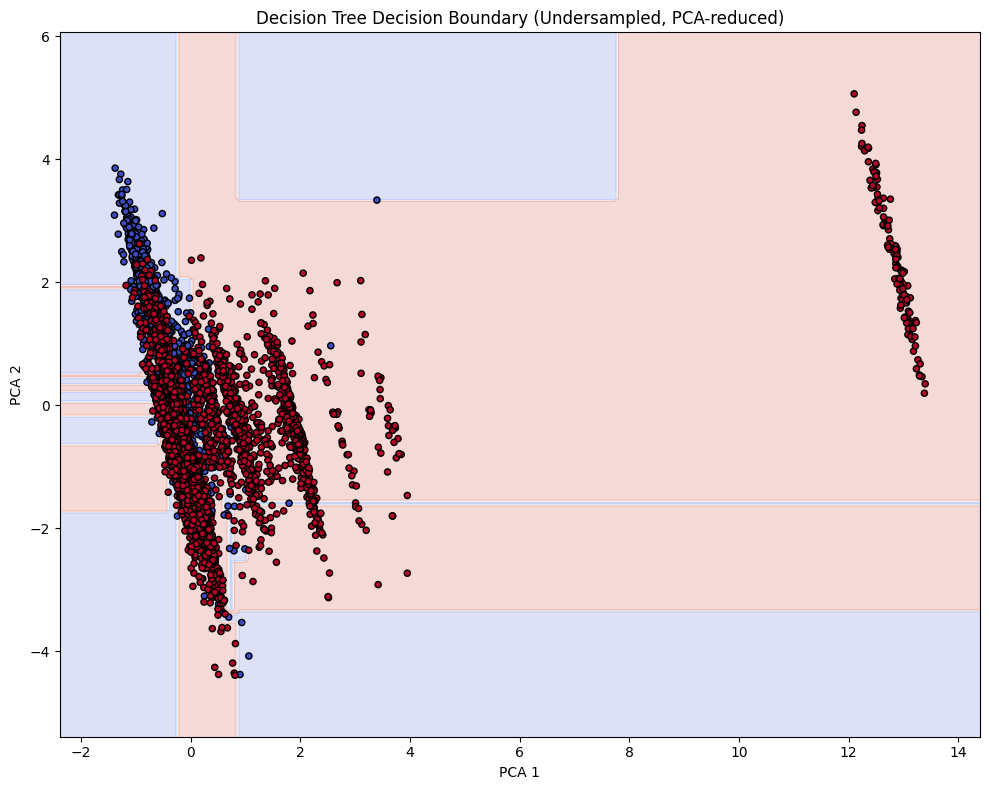

In [62]:
dtree_bal = DecisionTreeClassifier(random_state=42)
dtree_bal.fit(X_train_bal_2d, y_train_bal)

# Plot decision boundary
Z = dtree_bal.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X_train_bal_2d[:, 0], X_train_bal_2d[:, 1], c=y_train_bal, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
plt.title('Decision Tree Decision Boundary (Undersampled, PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.savefig('../assets/decision_tree_undersampled_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

### Decision Tree: Confusion Matrix and Metrics (Undersampled)

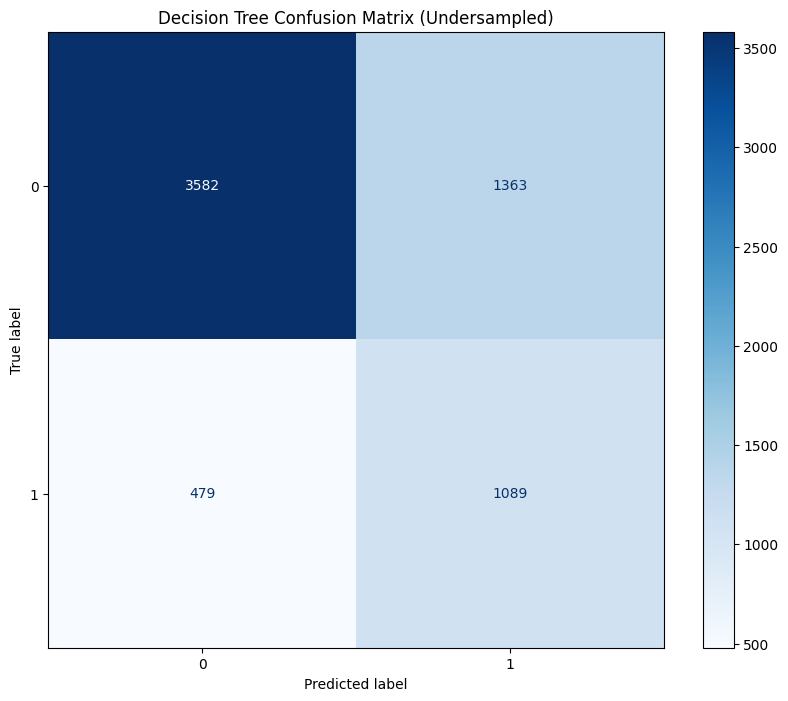

              precision    recall  f1-score   support

           0       0.88      0.72      0.80      4945
           1       0.44      0.69      0.54      1568

    accuracy                           0.72      6513
   macro avg       0.66      0.71      0.67      6513
weighted avg       0.78      0.72      0.73      6513

Train Accuracy: 0.900
Test Accuracy: 0.717


In [63]:
dtree_bal_test_pred = dtree_bal.predict(X_test_2d)
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, dtree_bal_test_pred, cmap='Blues', ax=ax)
plt.title('Decision Tree Confusion Matrix (Undersampled)')
plt.savefig('../assets/decision_tree_undersampled_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(y_test, dtree_bal_test_pred))
print(f"Train Accuracy: {dtree_bal.score(X_train_bal_2d, y_train_bal):.3f}")
print(f"Test Accuracy: {dtree_bal.score(X_test_2d, y_test):.3f}")

### Decision Tree Hyperparameter Tuning with GridSearchCV (Undersampled Data)
We will use GridSearchCV to find the best hyperparameters for the Decision Tree on the undersampled training data. The grid will include max_depth, min_samples_split, and min_samples_leaf. The best model will be evaluated on the test set.

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dtree_gs_undersample = DecisionTreeClassifier(random_state=42)
gs_undersample = GridSearchCV(dtree_gs_undersample, param_grid, cv=5, scoring='f1', n_jobs=-1)
gs_undersample.fit(X_train_bal, y_train_bal)

print("Best parameters:", gs_undersample.best_params_)
print("Best cross-validated F1 score:", gs_undersample.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validated F1 score: 0.7780060953778164


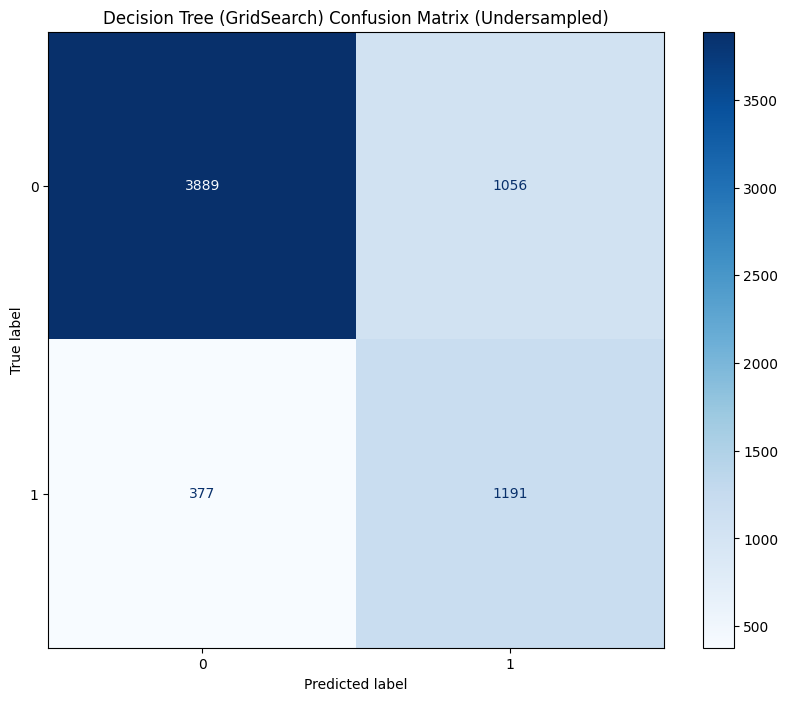

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      4945
           1       0.53      0.76      0.62      1568

    accuracy                           0.78      6513
   macro avg       0.72      0.77      0.73      6513
weighted avg       0.82      0.78      0.79      6513

Train Accuracy: 0.796
Test Accuracy: 0.780


In [65]:
# Evaluate the best estimator on the test set (all features, not PCA)
dtree_gs_undersample_test_pred = gs_undersample.best_estimator_.predict(X_test)
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, dtree_gs_undersample_test_pred, cmap='Blues', ax=ax)
plt.title('Decision Tree (GridSearch) Confusion Matrix (Undersampled)')
plt.savefig('../assets/decision_tree_gridsearch_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(y_test, dtree_gs_undersample_test_pred))
print(f"Train Accuracy: {gs_undersample.best_estimator_.score(X_train_bal, y_train_bal):.3f}")
print(f"Test Accuracy: {gs_undersample.best_estimator_.score(X_test, y_test):.3f}")

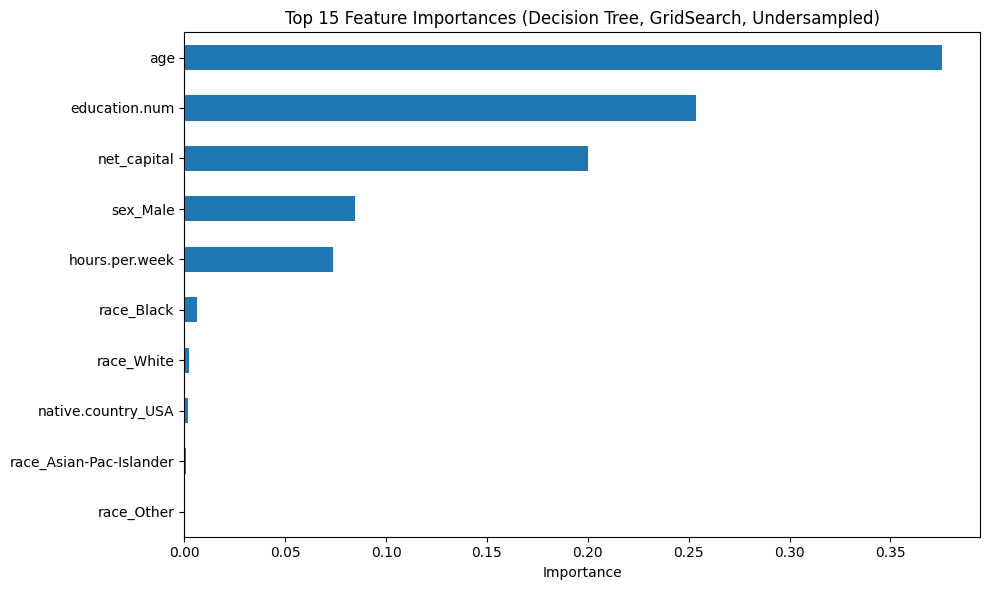

In [66]:
# Feature importance for best estimator (undersampled)
feature_names = X_train.columns
dtree_gs_undersample_importance = gs_undersample.best_estimator_.feature_importances_
dtree_gs_undersample_feat_imp = pd.Series(dtree_gs_undersample_importance, index=feature_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(10,6))
dtree_gs_undersample_feat_imp.plot(kind='barh')
plt.title('Top 15 Feature Importances (Decision Tree, GridSearch, Undersampled)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../assets/decision_tree_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
# Save available metrics and models for Streamlit dashboard
import os, json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

metrics = {
    'generated_at': datetime.utcnow().isoformat() + 'Z',
    'models': {}
}

# Helper to compute metrics if predictions available
def compute_metrics(y_true, y_pred):
    return {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'report': classification_report(y_true, y_pred, output_dict=True)
    }

# Try to collect Logistic Regression results
try:
    if 'logreg_test_pred' in globals() and 'y_test' in globals():
        metrics['models']['logistic_regression'] = compute_metrics(y_test, logreg_test_pred)
    if 'logreg' in globals():
        joblib.dump(logreg, MODELS_DIR / 'logistic_regression.pkl')
except Exception as e:
    metrics['models'].setdefault('logistic_regression', {})['error'] = str(e)

# Try to collect Decision Tree results
try:
    if 'dtree_test_pred' in globals() and 'y_test' in globals():
        metrics['models']['decision_tree'] = compute_metrics(y_test, dtree_test_pred)
    if 'dtree' in globals():
        joblib.dump(dtree, MODELS_DIR / 'decision_tree.pkl')
except Exception as e:
    metrics['models'].setdefault('decision_tree', {})['error'] = str(e)

# Save any known train/test accuracies if available
try:
    if 'logreg_train_acc' in globals():
        metrics['models'].setdefault('logistic_regression', {})['train_accuracy'] = float(logreg_train_acc)
    if 'logreg_acc' in globals():
        metrics['models'].setdefault('logistic_regression', {})['test_accuracy'] = float(logreg_acc)
    if 'dtree_train_acc' in globals():
        metrics['models'].setdefault('decision_tree', {})['train_accuracy'] = float(dtree_train_acc)
    if 'dtree_acc' in globals():
        metrics['models'].setdefault('decision_tree', {})['test_accuracy'] = float(dtree_acc)
except Exception as e:
    metrics.setdefault('errors', []).append(str(e))

# Persist feature names if available
try:
    if 'X_train' in globals():
        joblib.dump(list(getattr(X_train, 'columns', [])), MODELS_DIR / 'feature_names.pkl')
except Exception:
    pass

# Save metrics.json
with open(MODELS_DIR / 'metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)

print('Saved metrics to', MODELS_DIR / 'metrics.json')
print('Saved models (if available) to', MODELS_DIR)


Saved metrics to ..\models\metrics.json
Saved models (if available) to ..\models


In [68]:
# === Dashboard I/O setup (folders) ===
from pathlib import Path
import json, joblib

ASSETS_DIR = Path('../assets')
MODELS_DIR = Path('../models')
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print('Assets dir:', ASSETS_DIR.resolve())
print('Models dir:', MODELS_DIR.resolve())


Assets dir: F:\Adult-Income-Prediction\assets
Models dir: F:\Adult-Income-Prediction\models


In [69]:
# === Save model metrics and artifacts (idempotent) ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

metrics = { 'models': {} }

def compute_metrics(y_true, y_pred):
    return {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'report': classification_report(y_true, y_pred, output_dict=True)
    }

# Logistic Regression (if available)
try:
    if 'logreg_test_pred' in globals() and 'y_test' in globals():
        metrics['models']['logistic_regression'] = compute_metrics(y_test, logreg_test_pred)
    if 'logreg' in globals():
        joblib.dump(logreg, MODELS_DIR / 'logistic_regression.pkl')
except Exception as e:
    metrics.setdefault('errors', []).append(f'logreg: {e}')

# Decision Tree (if available)
try:
    if 'dtree_test_pred' in globals() and 'y_test' in globals():
        metrics['models']['decision_tree'] = compute_metrics(y_test, dtree_test_pred)
    if 'dtree' in globals():
        joblib.dump(dtree, MODELS_DIR / 'decision_tree.pkl')
except Exception as e:
    metrics.setdefault('errors', []).append(f'dtree: {e}')

# Optional: feature names
try:
    if 'X_train' in globals():
        joblib.dump(list(getattr(X_train, 'columns', [])), MODELS_DIR / 'feature_names.pkl')
except Exception:
    pass

# Optional: results table
try:
    if 'results_df' in globals():
        results_df.round(4).to_csv(MODELS_DIR / 'results_table.csv', index=False)
        results_df.round(4).to_json(MODELS_DIR / 'results_table.json', orient='records', indent=2)
except Exception as e:
    metrics.setdefault('errors', []).append(f'results_df: {e}')

with open(MODELS_DIR / 'metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)

print('Saved:', MODELS_DIR / 'metrics.json')


Saved: ..\models\metrics.json


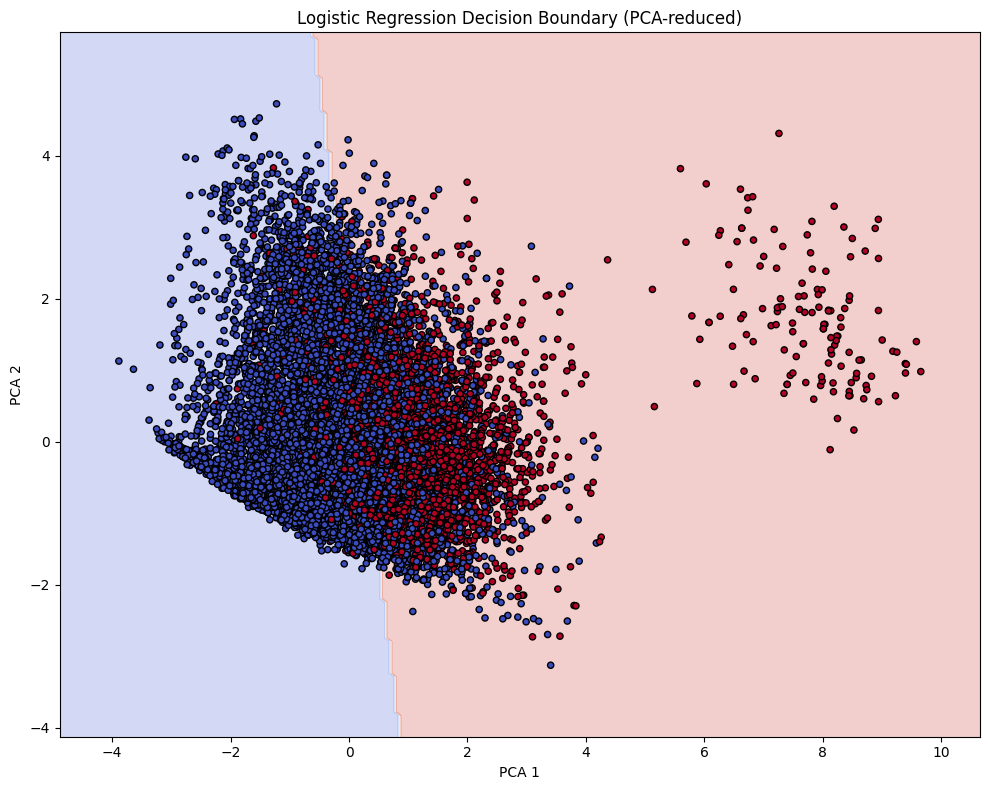

Saved: ..\assets\logistic_regression_decision_boundary.png


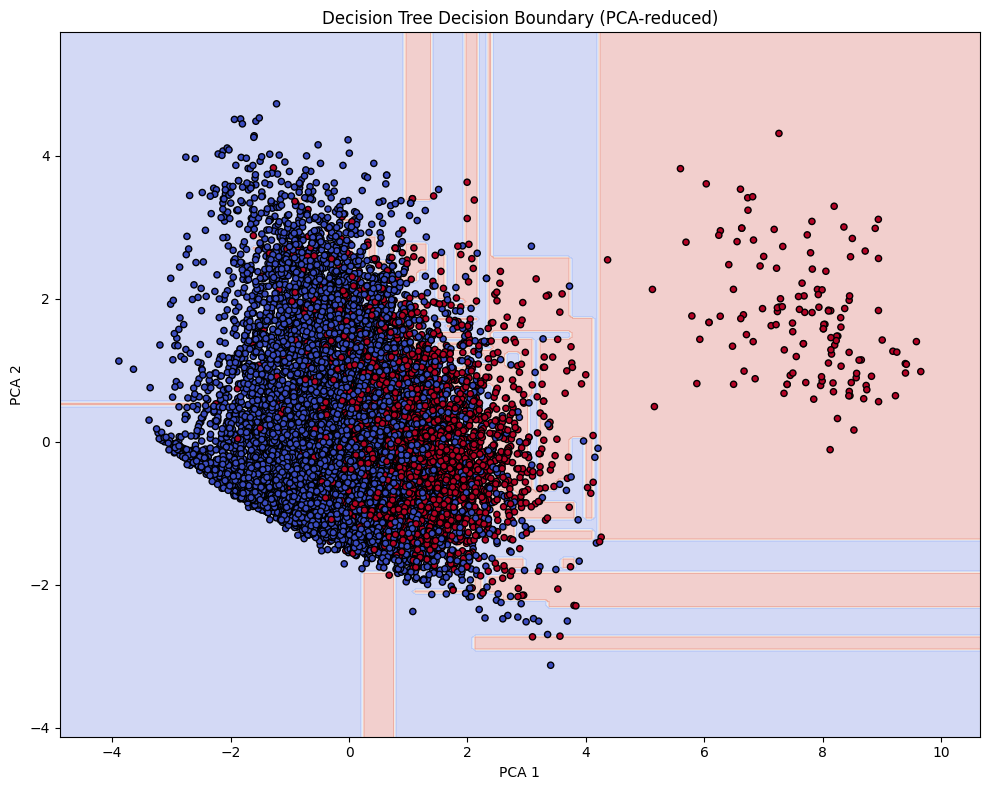

Saved: ..\assets\decision_tree_decision_boundary.png


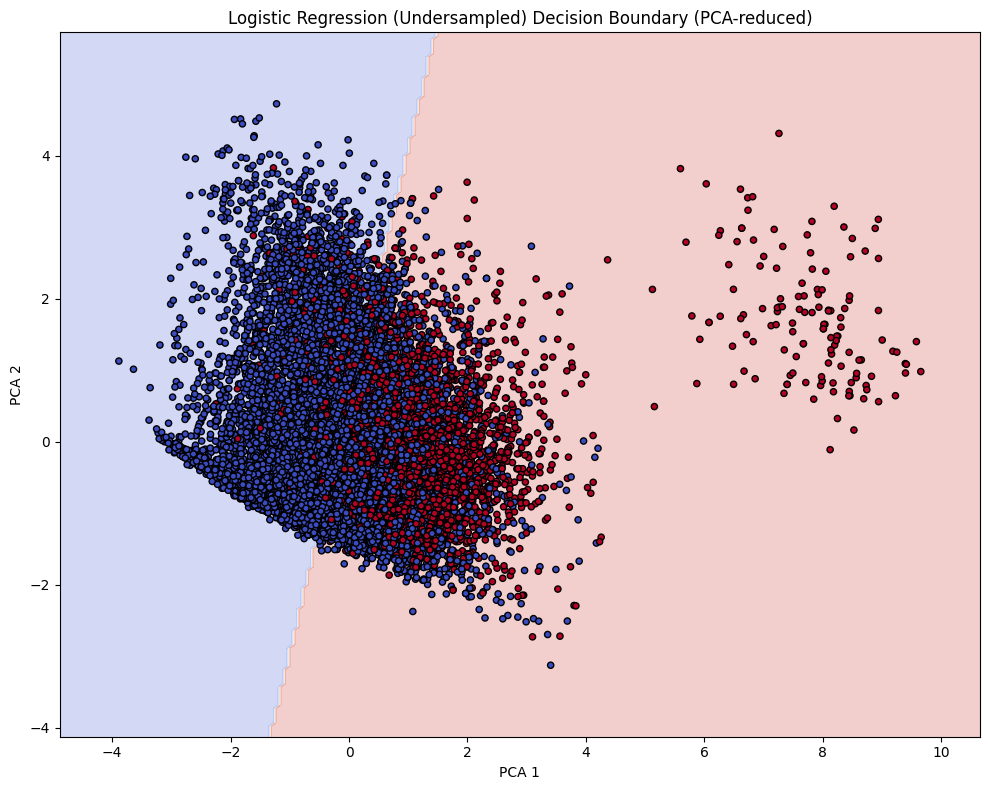

Saved: ..\assets\logistic_regression_undersampled_decision_boundary.png


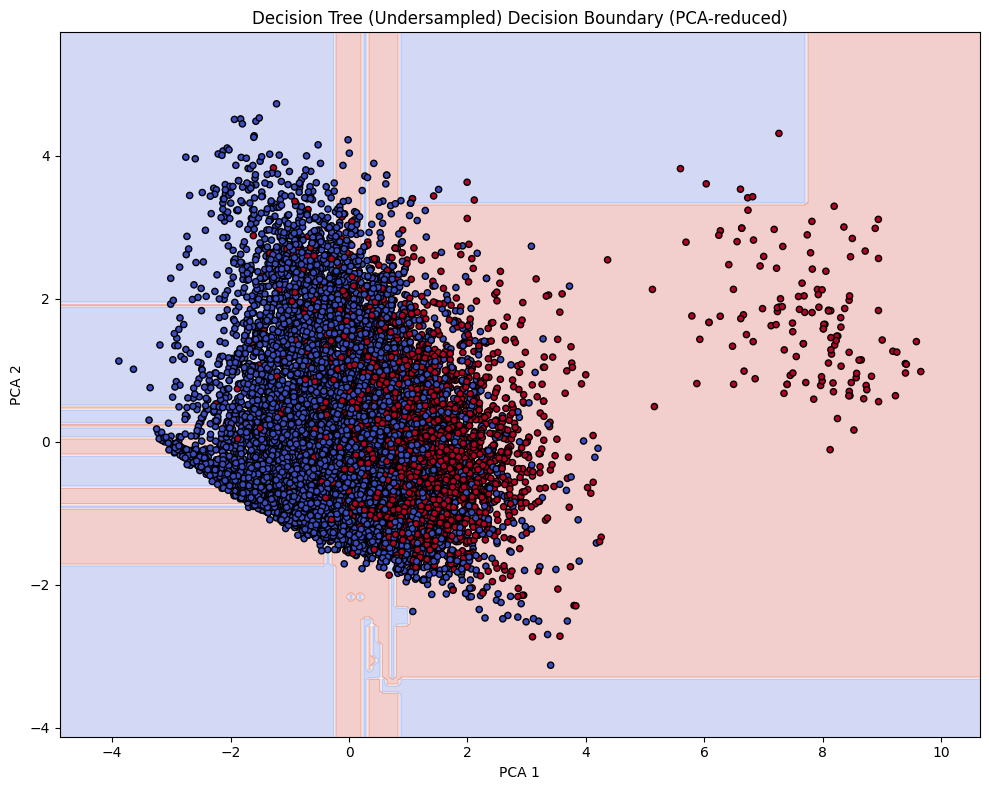

Saved: ..\assets\decision_tree_undersampled_decision_boundary.png
Could not plot Decision Tree (GridSearch, Undersampled): X has 2 features, but DecisionTreeClassifier is expecting 10 features as input.


c:\Users\omara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [70]:
# === Decision boundary plots for all available models (saved to assets) ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

ASSETS_DIR = Path('../assets')
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

# Prepare 2D projection
try:
    if 'X_train_2d' in globals() and 'X_test_2d' in globals():
        X_train_2d_local = X_train_2d
        X_test_2d_local = X_test_2d
    else:
        # Fall back: compute PCA on available train/test
        base_X_train = X_train if 'X_train' in globals() else X_train_scaled
        base_X_test = X_test if 'X_test' in globals() else X_test_scaled
        pca_local = PCA(n_components=2, random_state=42)
        X_train_2d_local = pca_local.fit_transform(base_X_train)
        X_test_2d_local = pca_local.transform(base_X_test)
except Exception as e:
    raise RuntimeError(f"Failed to prepare 2D data for decision boundaries: {e}")

# Common mesh grid
x_min, x_max = X_train_2d_local[:, 0].min() - 1, X_train_2d_local[:, 0].max() + 1
y_min, y_max = X_train_2d_local[:, 1].min() - 1, X_train_2d_local[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Helper to predict on 2D inputs

def plot_decision_boundary(model, model_name: str, X2d: np.ndarray, y: np.ndarray, file_stem: str):
    try:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.coolwarm)
        plt.scatter(X2d[:, 0], X2d[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
        plt.title(f"{model_name} Decision Boundary (PCA-reduced)")
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.tight_layout()
        out_path = ASSETS_DIR / f"{file_stem}.png"
        plt.savefig(out_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {out_path}")
    except Exception as e:
        print(f"Could not plot {model_name}: {e}")

# Determine labels for coloring (prefer training labels)
y_for_plot = y_train if 'y_train' in globals() else (y if 'y' in globals() else None)
if y_for_plot is None:
    raise RuntimeError('No labels available for decision boundary scatter plot.')

# Collect candidate models from the session
candidates = []
if 'logreg' in globals():
    candidates.append(('Logistic Regression', logreg, 'logistic_regression_decision_boundary'))
if 'dtree' in globals():
    candidates.append(('Decision Tree', dtree, 'decision_tree_decision_boundary'))
if 'logreg_bal' in globals():
    candidates.append(('Logistic Regression (Undersampled)', logreg_bal, 'logistic_regression_undersampled_decision_boundary'))
if 'dtree_bal' in globals():
    candidates.append(('Decision Tree (Undersampled)', dtree_bal, 'decision_tree_undersampled_decision_boundary'))
# GridSearch best estimator (undersample)
if 'gs_undersample' in globals():
    try:
        best_dt = gs_undersample.best_estimator_
        candidates.append(('Decision Tree (GridSearch, Undersampled)', best_dt, 'decision_tree_gridsearch_decision_boundary'))
    except Exception:
        pass

# Plot for each candidate
for name, model, stem in candidates:
    plot_decision_boundary(model, name, X_train_2d_local, y_for_plot.values if hasattr(y_for_plot, 'values') else y_for_plot, stem)


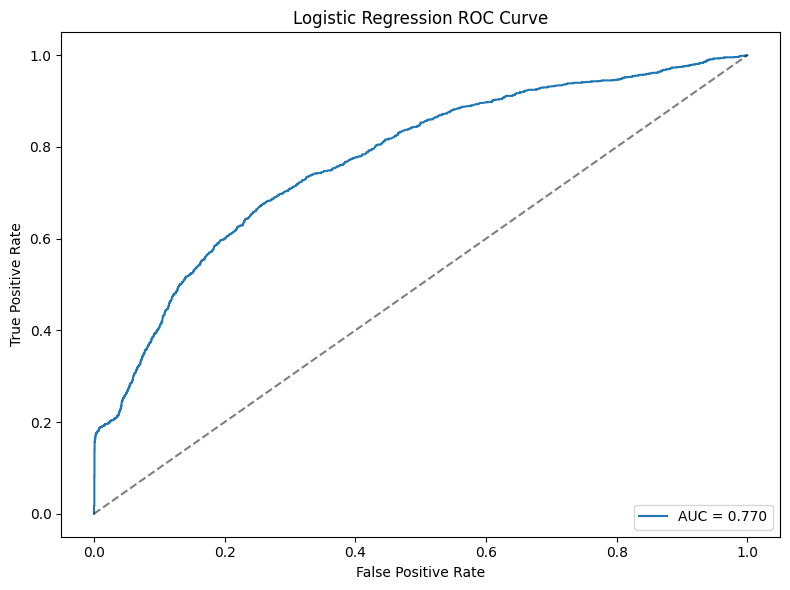

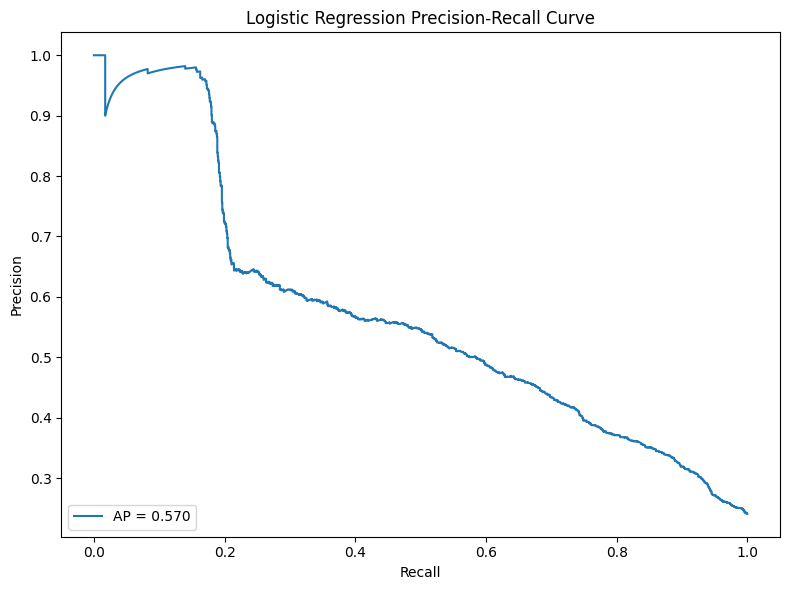

Could not save feature importance for Logistic Regression: Length of values (2) does not match length of index (10)


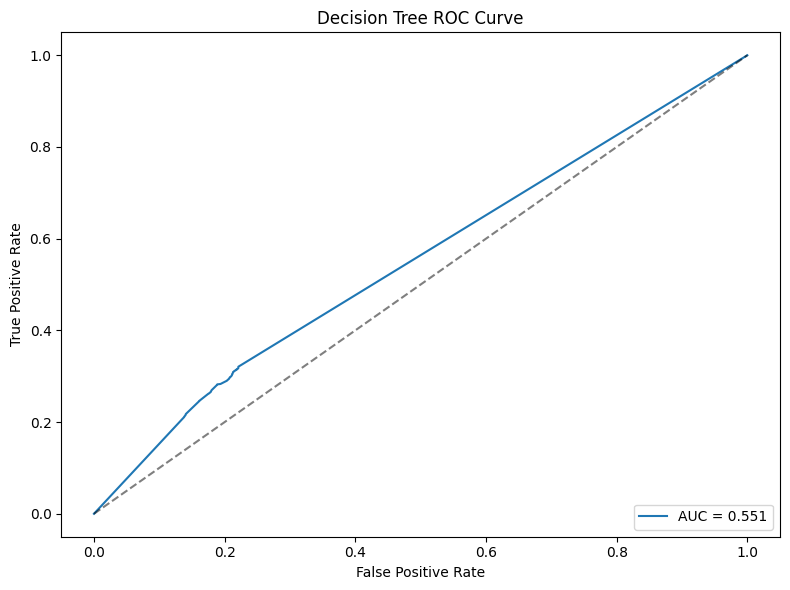

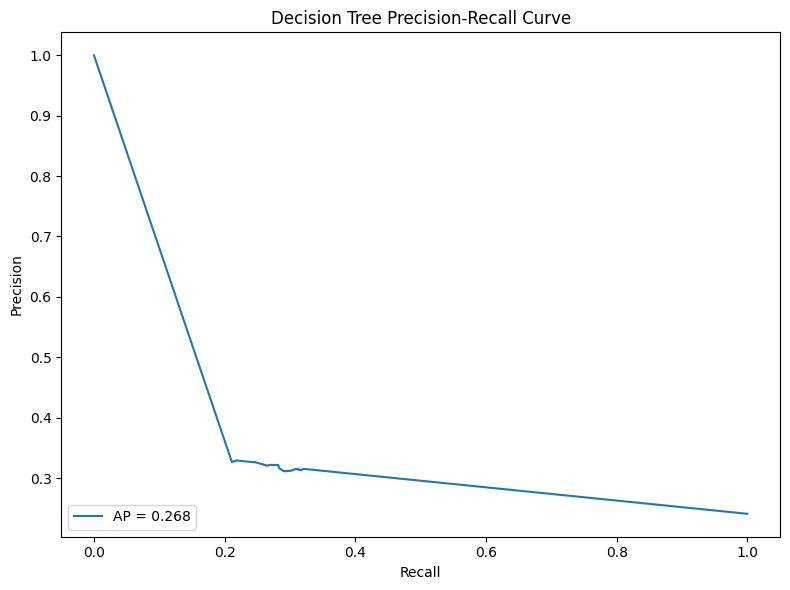

Could not save feature importance for Decision Tree: Length of values (2) does not match length of index (10)


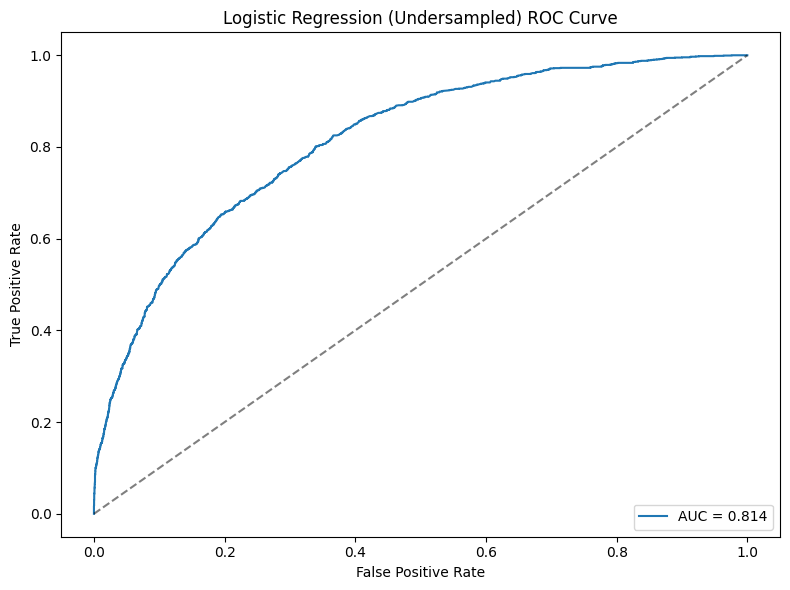

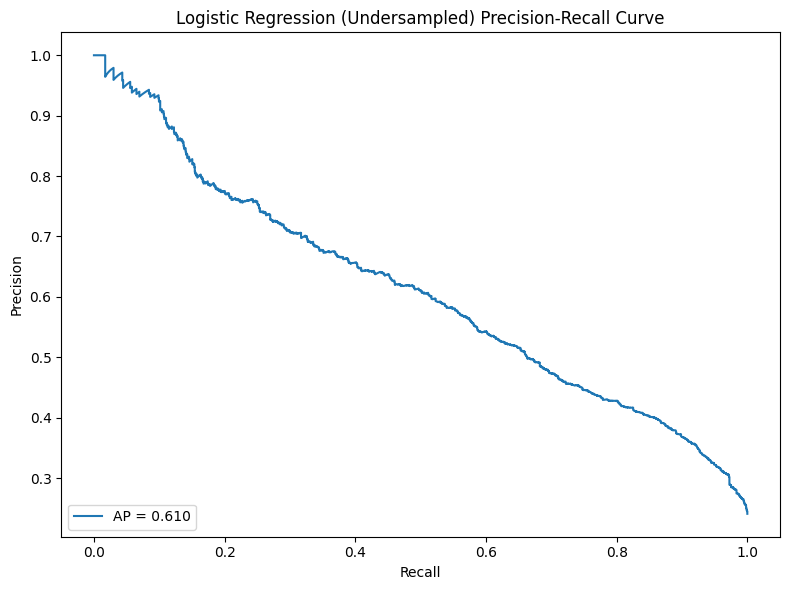

Could not save feature importance for Logistic Regression (Undersampled): Length of values (2) does not match length of index (10)


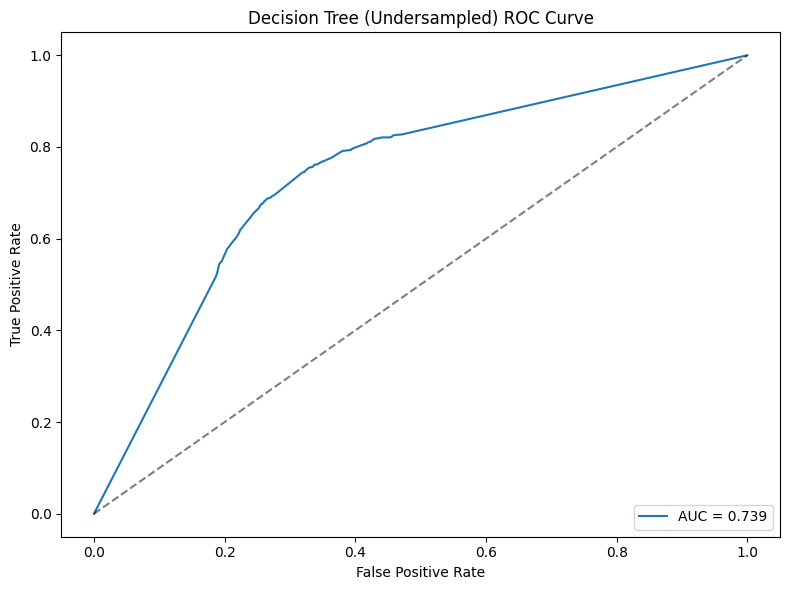

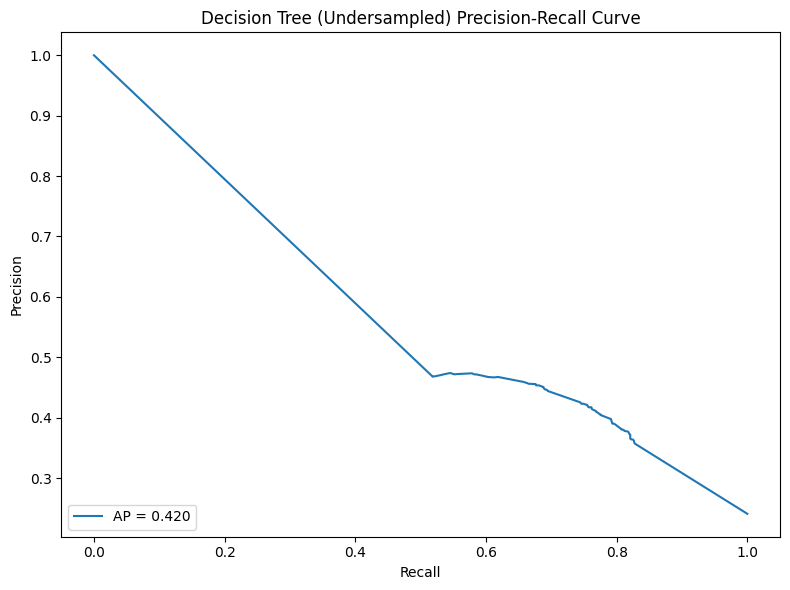

Could not save feature importance for Decision Tree (Undersampled): Length of values (2) does not match length of index (10)


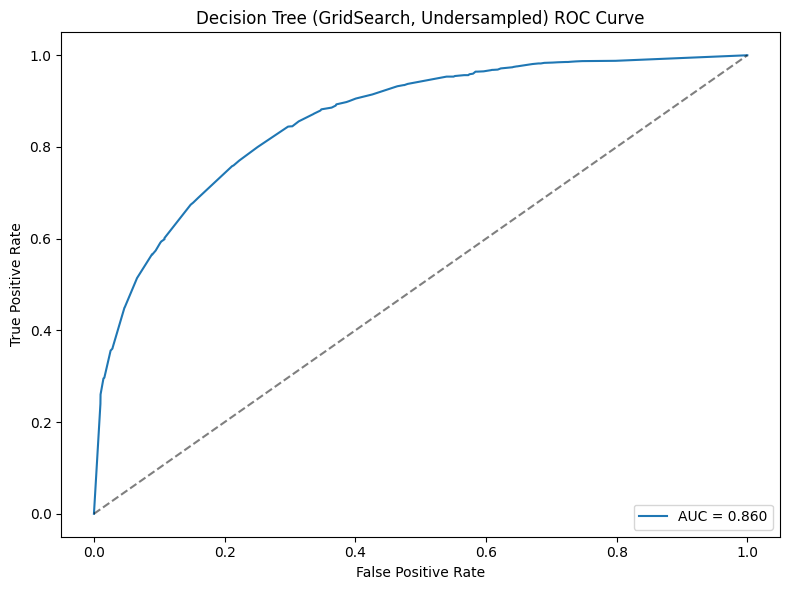

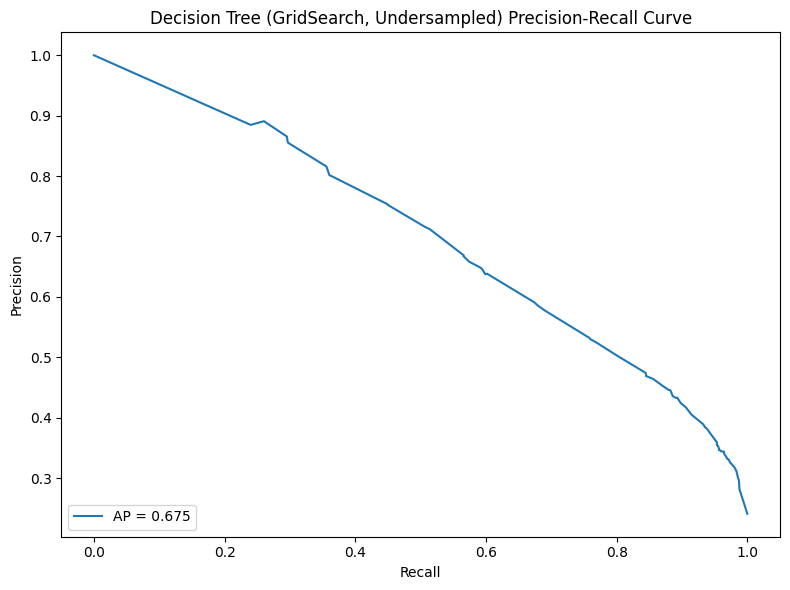

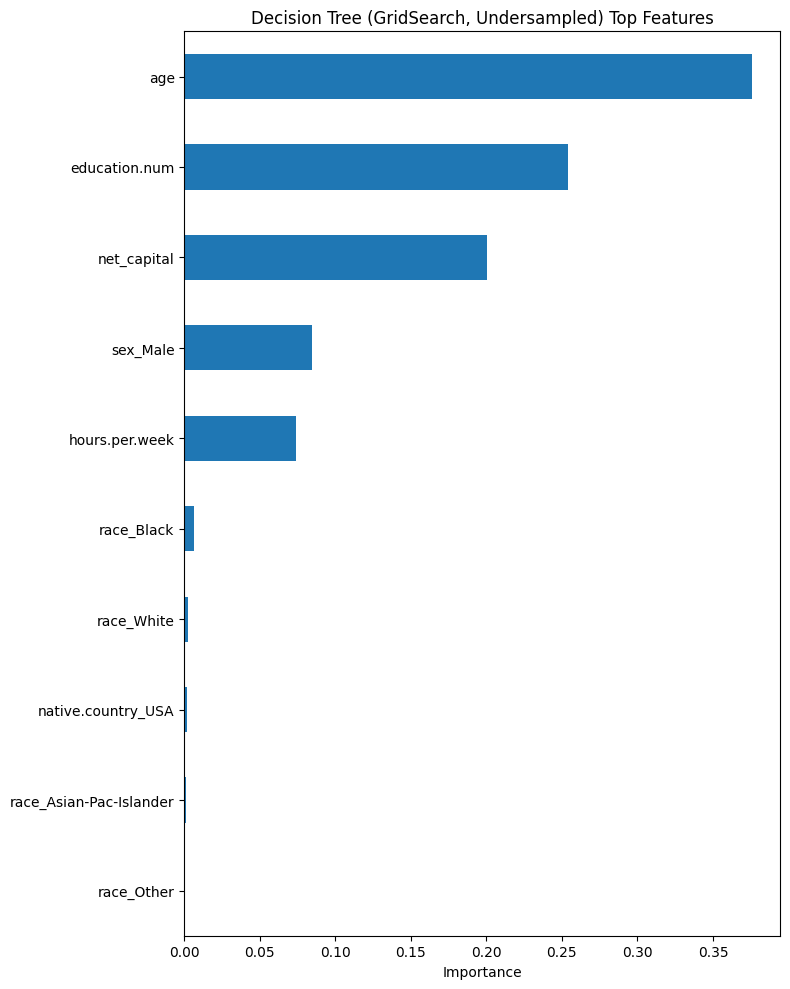

In [71]:
# === Save ROC, PR, and Feature Importance plots for available models ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from pathlib import Path

ASSETS_DIR = Path('../assets')
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

# Helper functions

def save_roc_pr_curves(model_name: str, y_true, y_proba, stem_prefix: str):
    try:
        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        ax.plot([0,1],[0,1], 'k--', alpha=0.5)
        ax.set_title(f'{model_name} ROC Curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        fig.tight_layout()
        fig.savefig(ASSETS_DIR / f'{stem_prefix}_roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # PR
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        ap = average_precision_score(y_true, y_proba)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(recall, precision, label=f'AP = {ap:.3f}')
        ax.set_title(f'{model_name} Precision-Recall Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower left')
        fig.tight_layout()
        fig.savefig(ASSETS_DIR / f'{stem_prefix}_pr_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f'Could not save ROC/PR for {model_name}:', e)


def save_feature_importance(model, model_name: str, feature_names, stem_prefix: str):
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_') and np.ndim(model.coef_) == 2:
            importances = np.abs(model.coef_[0])
        else:
            return
        
        import pandas as pd
        fi = pd.Series(importances, index=feature_names)
        top = fi.sort_values(ascending=False).head(20)
        fig, ax = plt.subplots(figsize=(8,10))
        top.sort_values().plot(kind='barh', ax=ax)
        ax.set_title(f'{model_name} Top Features')
        ax.set_xlabel('Importance')
        fig.tight_layout()
        fig.savefig(ASSETS_DIR / f'{stem_prefix}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f'Could not save feature importance for {model_name}:', e)

# Determine available models and proba predictions
candidates_proba = []
feature_names = list(getattr(X_train, 'columns', [])) if 'X_train' in globals() else None

if 'logreg' in globals():
    try:
        y_proba = logreg.predict_proba(X_test_2d if 'X_test_2d' in globals() else X_test)[:,1]
        candidates_proba.append(('Logistic Regression', logreg, y_proba, 'logistic_regression'))
    except Exception:
        pass

if 'dtree' in globals():
    try:
        y_proba = dtree.predict_proba(X_test_2d if 'X_test_2d' in globals() else X_test)[:,1]
        candidates_proba.append(('Decision Tree', dtree, y_proba, 'decision_tree'))
    except Exception:
        pass

if 'logreg_bal' in globals():
    try:
        y_proba = logreg_bal.predict_proba(X_test_2d if 'X_test_2d' in globals() else X_test)[:,1]
        candidates_proba.append(('Logistic Regression (Undersampled)', logreg_bal, y_proba, 'logistic_regression_undersampled'))
    except Exception:
        pass

if 'dtree_bal' in globals():
    try:
        y_proba = dtree_bal.predict_proba(X_test_2d if 'X_test_2d' in globals() else X_test)[:,1]
        candidates_proba.append(('Decision Tree (Undersampled)', dtree_bal, y_proba, 'decision_tree_undersampled'))
    except Exception:
        pass

if 'gs_undersample' in globals():
    try:
        best_dt = gs_undersample.best_estimator_
        y_proba = best_dt.predict_proba(X_test)[:,1]
        candidates_proba.append(('Decision Tree (GridSearch, Undersampled)', best_dt, y_proba, 'decision_tree_gridsearch'))
    except Exception:
        pass

# Save for each candidate
for name, model, y_proba, stem in candidates_proba:
    if 'y_test' in globals():
        save_roc_pr_curves(name, y_test, y_proba, stem)
    if feature_names is not None:
        save_feature_importance(model, name, feature_names, stem)


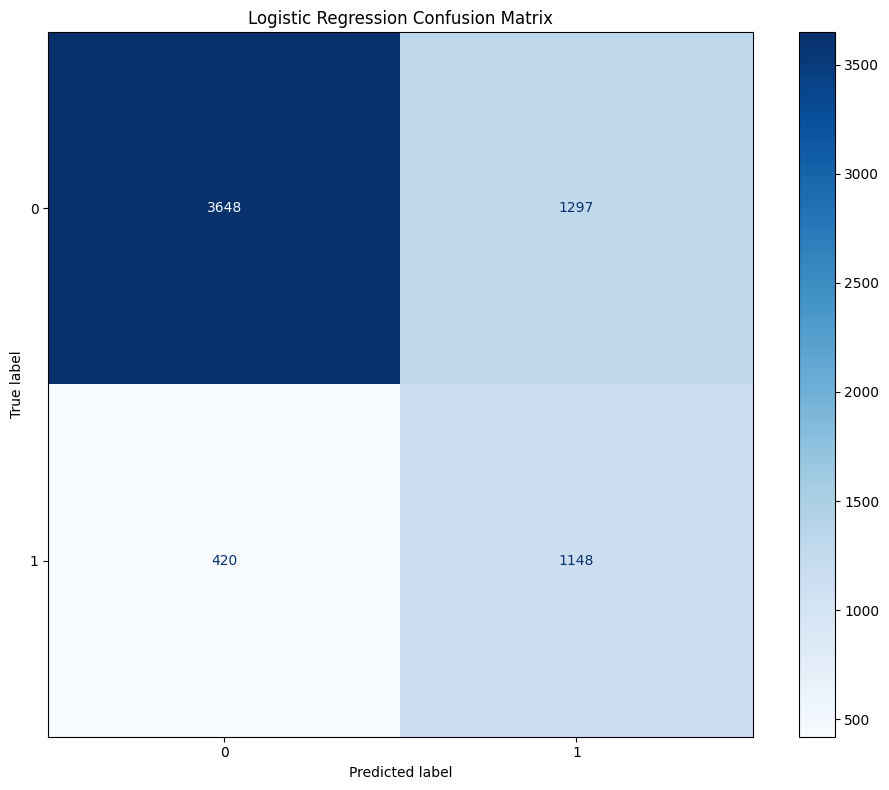

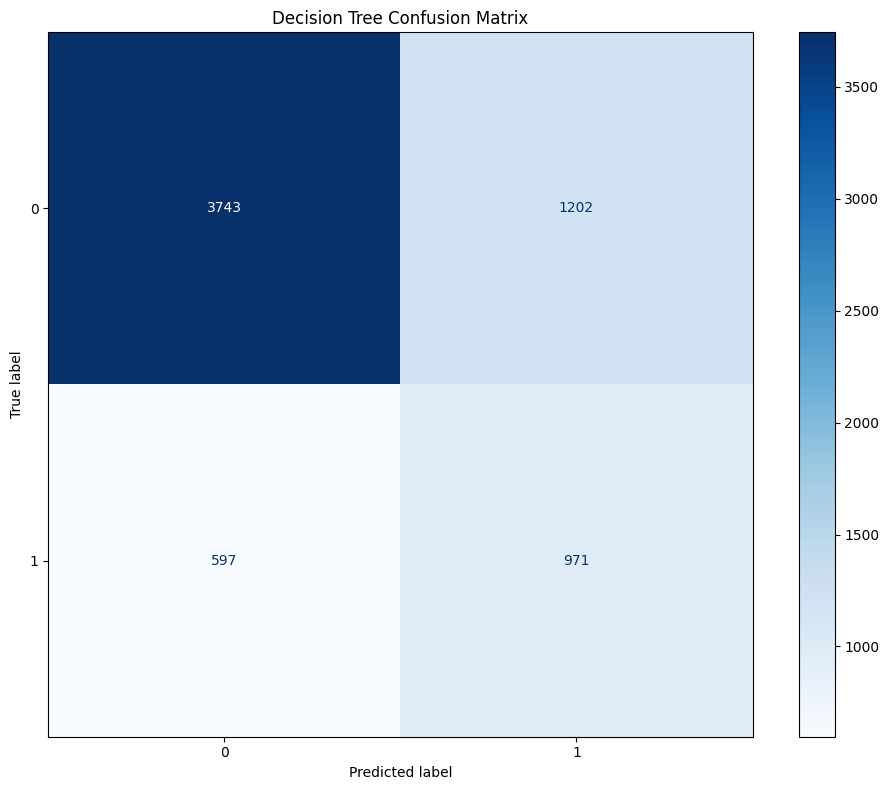

In [72]:
# === Examples: save plots to assets ===
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Example: logistic regression confusion matrix (if variables exist)
try:
    if 'logreg_test_pred' in globals() and 'y_test' in globals():
        fig, ax = plt.subplots(figsize=(10,8))
        ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_pred, cmap='Blues', ax=ax)
        plt.title('Logistic Regression Confusion Matrix')
        plt.tight_layout()
        fig.savefig(ASSETS_DIR / 'logistic_regression_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print('Could not save logistic regression confusion matrix:', e)

# Example: decision tree confusion matrix (if variables exist)
try:
    if 'dtree_test_pred' in globals() and 'y_test' in globals():
        fig, ax = plt.subplots(figsize=(10,8))
        ConfusionMatrixDisplay.from_predictions(y_test, dtree_test_pred, cmap='Blues', ax=ax)
        plt.title('Decision Tree Confusion Matrix')
        plt.tight_layout()
        fig.savefig(ASSETS_DIR / 'decision_tree_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print('Could not save decision tree confusion matrix:', e)

# Pattern for any other existing figure:
# fig.tight_layout(); fig.savefig(ASSETS_DIR / 'your_plot.png', dpi=300, bbox_inches='tight'); plt.show()



logistic_regression accuracy: 0.7930


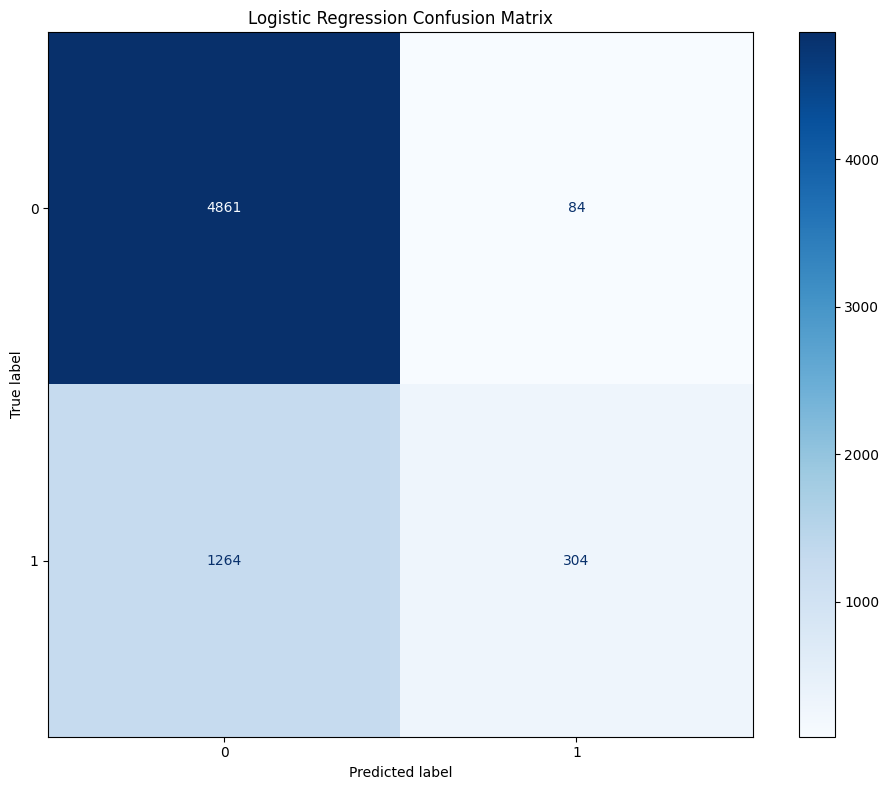

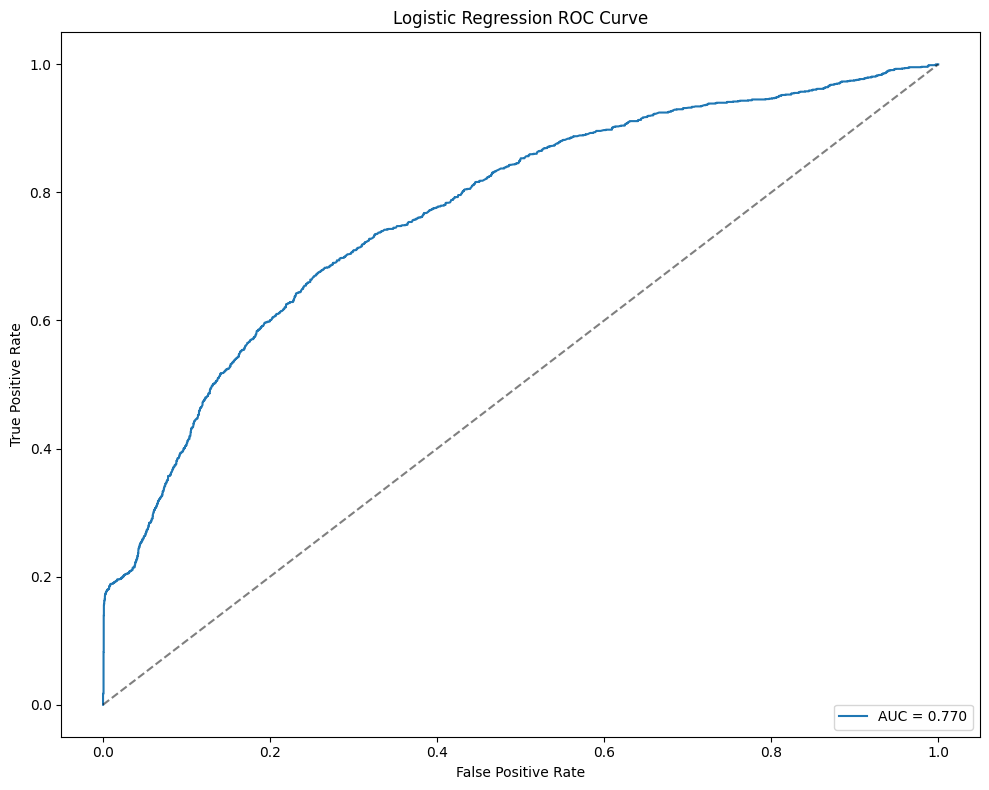

decision_tree accuracy: 0.6834


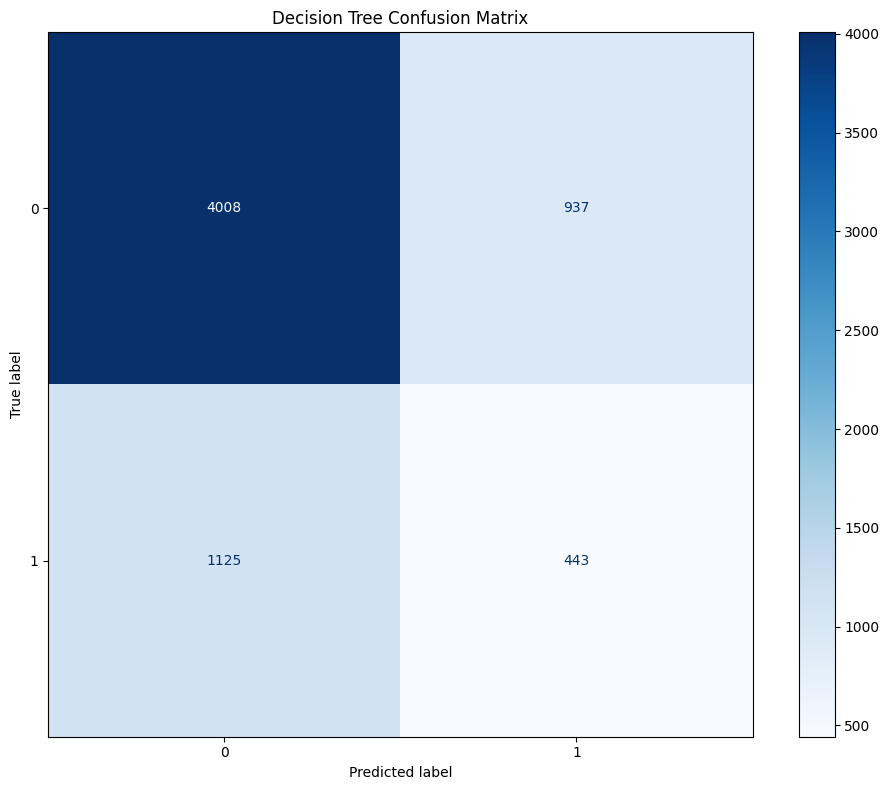

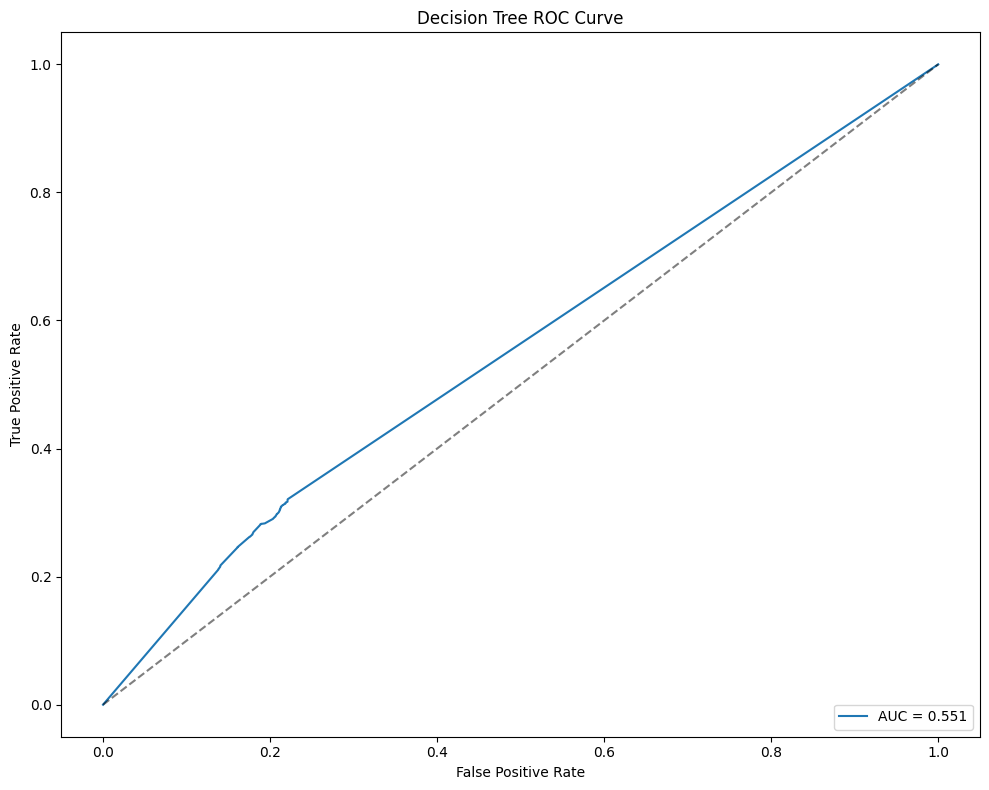

logistic_regression_undersampled accuracy: 0.7394


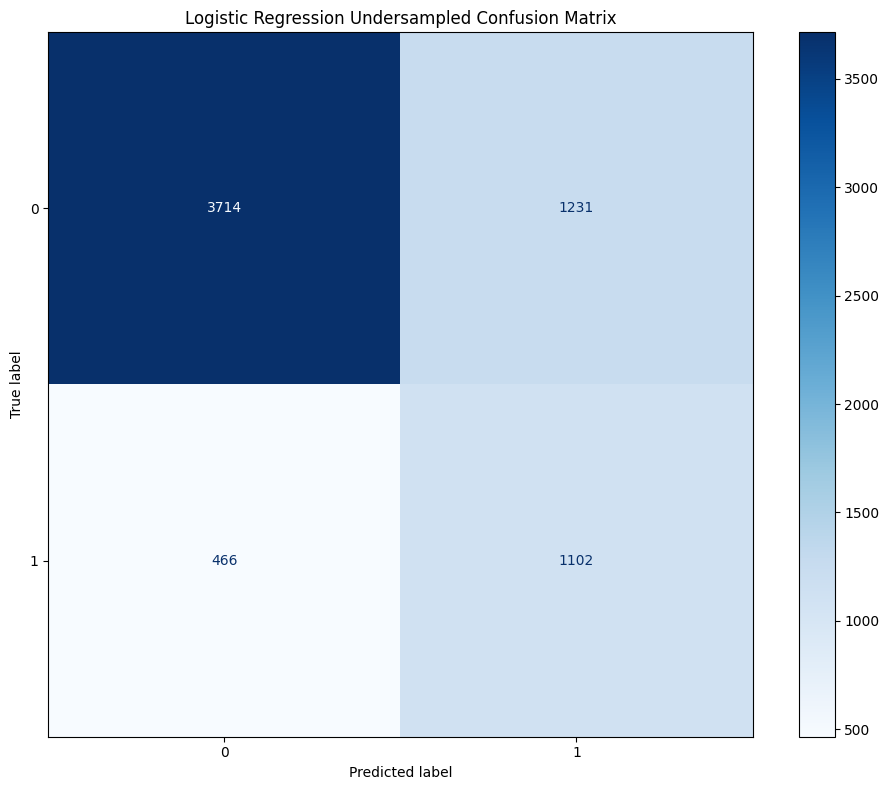

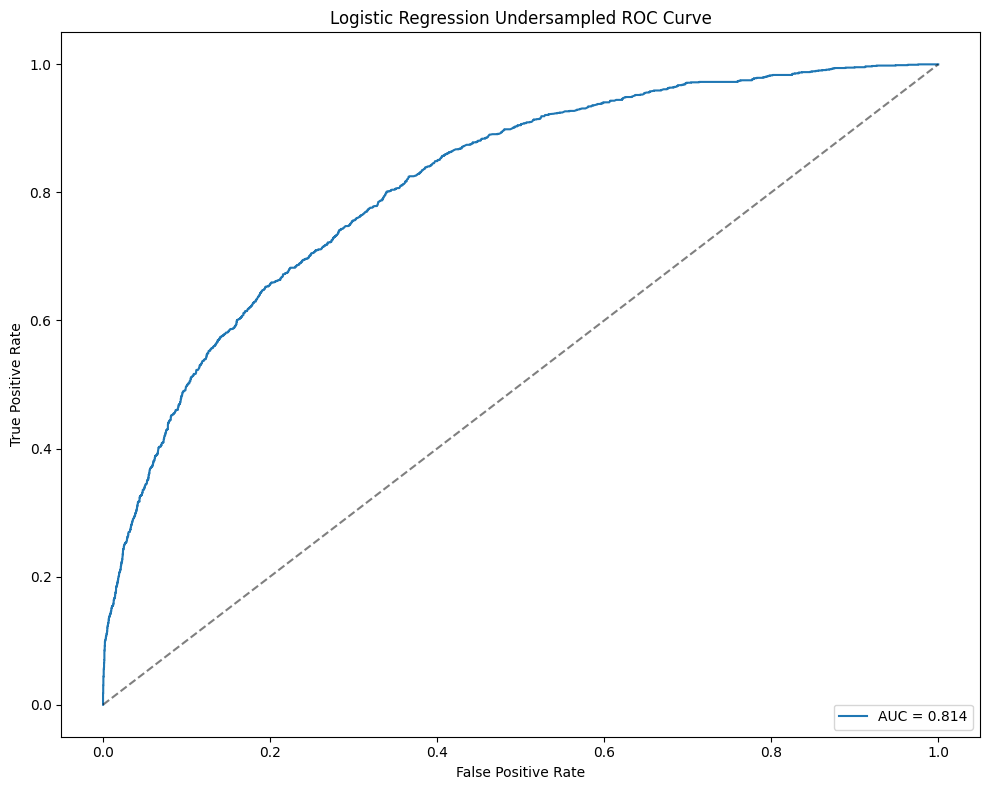

decision_tree_undersampled accuracy: 0.7172


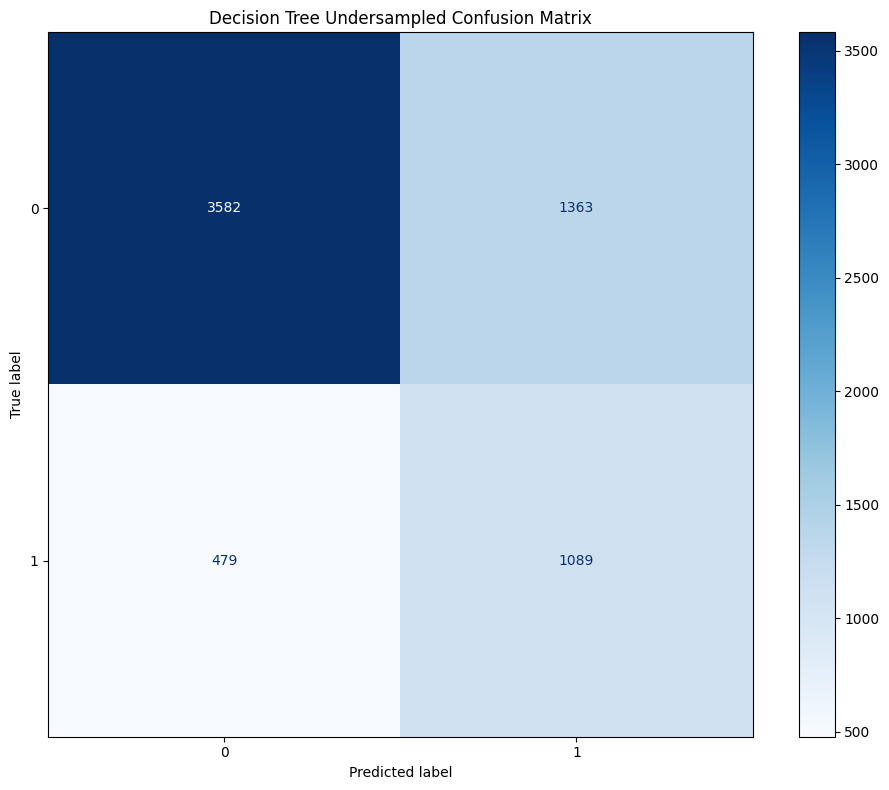

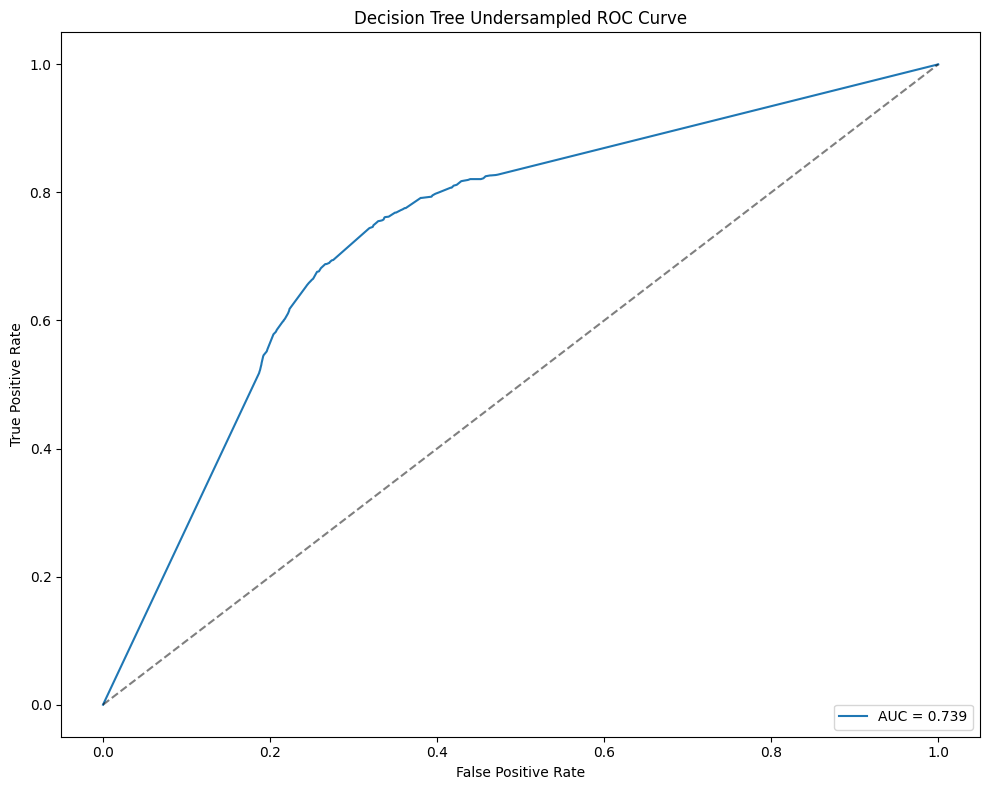

decision_tree_gridsearch accuracy: 0.7800


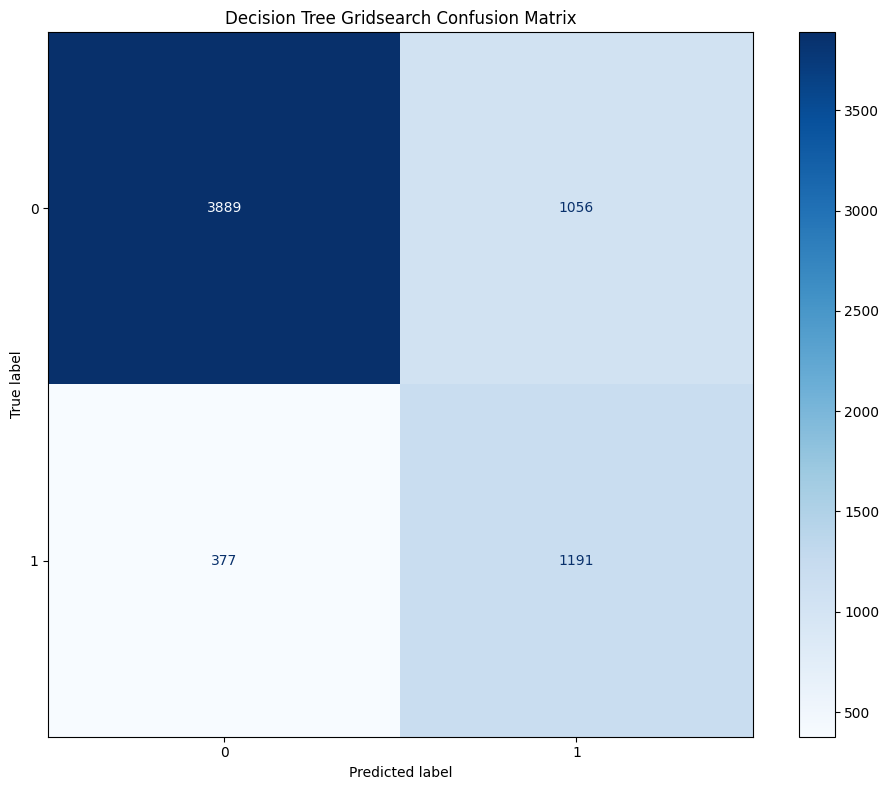

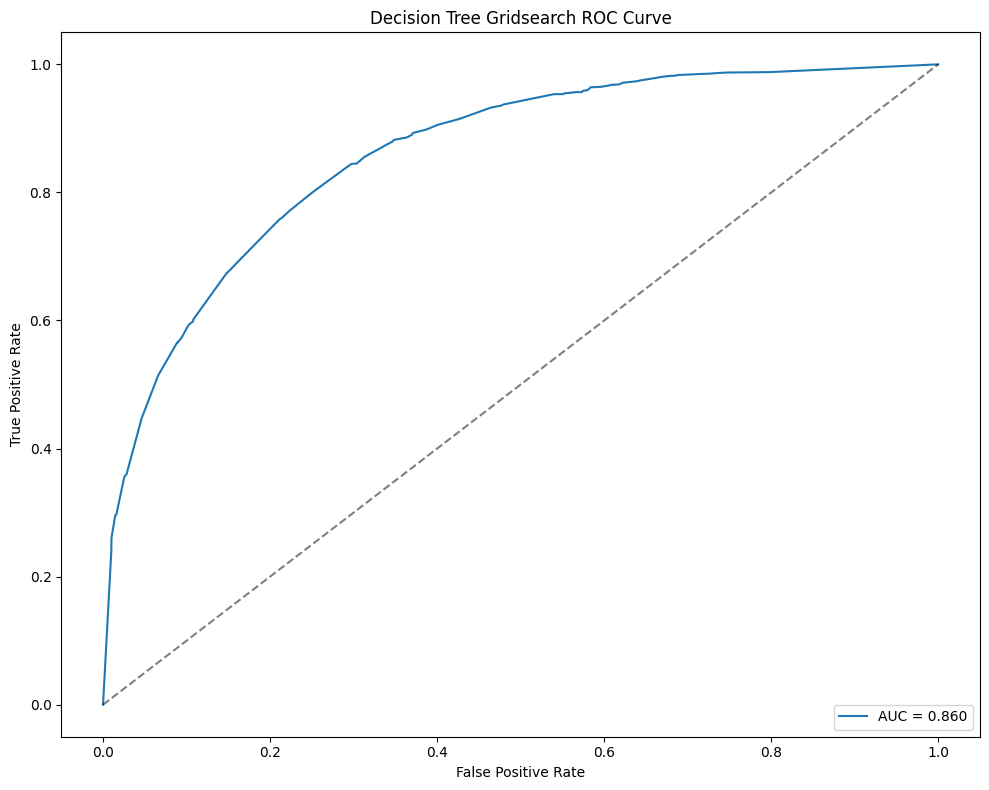

In [73]:
# === Consolidated per-model outputs: accuracy, confusion matrix, ROC AUC ===
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

ASSETS_DIR = Path('../assets')
MODELS_DIR = Path('../models')
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Utility to evaluate and persist plots for a model

def eval_and_save(model, model_key: str, X_eval, y_eval):
    try:
        y_pred = model.predict(X_eval)
        # Probabilities for ROC
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_eval)[:, 1]
        elif hasattr(model, 'decision_function'):
            # Fallback if available
            from sklearn.preprocessing import MinMaxScaler
            scores = model.decision_function(X_eval)
            y_proba = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()
        else:
            y_proba = None
        
        # Accuracy
        acc = float((y_pred == y_eval).mean())
        print(f'{model_key} accuracy: {acc:.4f}')
        
        # Save to metrics.json
        try:
            import json
            metrics_path = MODELS_DIR / 'metrics.json'
            if metrics_path.exists():
                with open(metrics_path, 'r', encoding='utf-8') as f:
                    metrics = json.load(f)
            else:
                metrics = {'models': {}}
            m = metrics['models'].setdefault(model_key, {})
            m['accuracy'] = acc
            with open(metrics_path, 'w', encoding='utf-8') as f:
                json.dump(metrics, f, indent=2)
        except Exception as e:
            print('Could not update metrics.json:', e)
        
        # Confusion matrix
        fig, ax = plt.subplots(figsize=(10,8))
        ConfusionMatrixDisplay.from_predictions(y_eval, y_pred, cmap='Blues', ax=ax)
        ax.set_title(f'{model_key.replace("_"," ").title()} Confusion Matrix')
        fig.tight_layout()
        fig.savefig(ASSETS_DIR / f'{model_key}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # ROC AUC
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_eval, y_proba)
            roc_auc = auc(fpr, tpr)
            fig, ax = plt.subplots(figsize=(10,8))
            ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
            ax.plot([0,1],[0,1],'k--', alpha=0.5)
            ax.set_title(f'{model_key.replace("_"," ").title()} ROC Curve')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc='lower right')
            fig.tight_layout()
            fig.savefig(ASSETS_DIR / f'{model_key}_roc_curve.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(f'Failed to evaluate {model_key}:', e)

# Choose evaluation features for each model
# If a model was trained in 2D (PCA), evaluate on X_test_2d else X_test/X_test_scaled

def pick_eval_X(model_key: str):
    # Heuristic: models trained in PCA in this notebook used *_2d variables
    if model_key in ['logistic_regression', 'decision_tree'] and 'X_test_2d' in globals():
        return X_test_2d
    # Undersampled PCA variants
    if model_key in ['logistic_regression_undersampled', 'decision_tree_undersampled'] and 'X_test_2d' in globals():
        return X_test_2d
    # GridSearch best estimator used full X
    if model_key == 'decision_tree_gridsearch' and 'X_test' in globals():
        return X_test
    # Fallback preference
    if 'X_test_scaled' in globals():
        return X_test_scaled
    return X_test

# Map available models in session to canonical keys used by dashboard
models_available = []
if 'logreg' in globals():
    models_available.append(('logreg', 'logistic_regression', logreg))
if 'dtree' in globals():
    models_available.append(('dtree', 'decision_tree', dtree))
if 'logreg_bal' in globals():
    models_available.append(('logreg_bal', 'logistic_regression_undersampled', logreg_bal))
if 'dtree_bal' in globals():
    models_available.append(('dtree_bal', 'decision_tree_undersampled', dtree_bal))
if 'gs_undersample' in globals():
    try:
        models_available.append(('gs_undersample', 'decision_tree_gridsearch', gs_undersample.best_estimator_))
    except Exception:
        pass

# Evaluate sequentially in the order requested
for var_name, key, mdl in models_available:
    X_eval = pick_eval_X(key)
    eval_and_save(mdl, key, X_eval, y_test)

